In [ ]:
# Cell 1: Imports and Config
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import json
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm, trange
from tqdm.auto import tqdm as std_tqdm
from copy import deepcopy

In [2]:
@dataclass
class ExperimentConfig:
    seeds: List[int]
    epochs_per_phase: int
    batch_size: int
    learning_rate: float
    probe_points: List[str]
    dropout_rates: List[float]  # Added dropout rates
    data_path: str = './data'
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    def to_dict(self):
        return {
            'seeds': self.seeds,
            'epochs_per_phase': self.epochs_per_phase,
            'batch_size': self.batch_size,
            'learning_rate': self.learning_rate,
            'probe_points': self.probe_points,
            'dropout_rates': self.dropout_rates,
            'data_path': self.data_path,
            'device': self.device
        }

    @classmethod
    def default_config(cls):
        return cls(
            seeds=[42, 123, 456],
            epochs_per_phase=30,
            batch_size=128,
            learning_rate=0.001,
            probe_points=['conv2', 'conv4', 'conv6'],
            dropout_rates=[0.0, 0.5],  # Test with and without dropout
            data_path='./data'
        )

In [3]:
class CIFAR10Manager:
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                               (0.2023, 0.1994, 0.2010))
        ])

        self.transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                               (0.2023, 0.1994, 0.2010))
        ])

        self._train_dataset = None
        self._test_dataset = None

    @property
    def train_dataset(self):
        if self._train_dataset is None:
            self._train_dataset = datasets.CIFAR10(
                self.config.data_path,
                train=True,
                download=True,
                transform=self.transform_train
            )
        return self._train_dataset

    @property
    def test_dataset(self):
        if self._test_dataset is None:
            self._test_dataset = datasets.CIFAR10(
                self.config.data_path,
                train=False,
                transform=self.transform_test
            )
        return self._test_dataset

    def get_loaders(self):
        train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.config.batch_size * 2,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        return train_loader, test_loader

In [4]:
# Cell 3: Updated Model Definition
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class CIFAR10Net(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()

        self.layers = nn.ModuleDict({
            'conv1': nn.Sequential(
                ConvBlock(3, 64),
                ConvBlock(64, 64),
            ),
            'conv2': nn.Sequential(
                nn.MaxPool2d(2),
                ConvBlock(64, 128),
                ConvBlock(128, 128),
            ),
            'conv3': nn.Sequential(
                nn.MaxPool2d(2),
                ConvBlock(128, 256),
                ConvBlock(256, 256),
            ),
            'conv4': nn.Sequential(
                nn.MaxPool2d(2),
                ConvBlock(256, 512),
                ConvBlock(512, 512),
            ),
            'conv5': nn.Sequential(
                ConvBlock(512, 512),
                ConvBlock(512, 512),
            ),
            'conv6': nn.Sequential(
                nn.MaxPool2d(2),
                ConvBlock(512, 512),
            ),
            'fc1': nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(512 * 2 * 2, 1024),
                nn.ReLU(inplace=True),
            ),
            'fc2': nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(1024, 10)
            )
        })

        self.layer_order = ['conv1', 'conv2', 'conv3', 'conv4',
                           'conv5', 'conv6', 'fc1', 'fc2']
        self.dropout_rate = dropout_rate

    def forward(self, x):
        for layer_name in self.layer_order:
            x = self.layers[layer_name](x)
            if layer_name == 'conv6':  # Flatten before FC layers
                x = x.view(x.size(0), -1)
        return x

    def reinitialize_from(self, layer_name, freeze_previous=False):
        """
        Reinitialize all layers after the specified layer and optionally freeze previous layers.
        
        Args:
            layer_name (str): Name of the layer to reinitialize from
            freeze_previous (bool): If True, freeze all layers before the specified layer
        
        Returns:
            int: Index where reinitialization starts
        """
        start_idx = self.layer_order.index(layer_name) + 1
        
        # Handle freezing of previous layers
        if freeze_previous:
            for layer_idx in range(start_idx):
                layer = self.layers[self.layer_order[layer_idx]]
                for param in layer.parameters():
                    param.requires_grad = False
        
        # Reinitialize subsequent layers
        for layer_idx in range(start_idx, len(self.layer_order)):
            layer = self.layers[self.layer_order[layer_idx]]
            for module in layer.modules():
                if isinstance(module, (nn.Conv2d, nn.Linear)):
                    nn.init.kaiming_normal_(module.weight)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)
                elif isinstance(module, nn.BatchNorm2d):
                    nn.init.constant_(module.weight, 1)
                    nn.init.constant_(module.bias, 0)
                    
        return start_idx
    
    def unfreeze_all_layers(self):
        """Unfreeze all layers in the network"""
        for layer in self.layers.values():
            for param in layer.parameters():
                param.requires_grad = True

In [5]:
class Trainer:
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.device = torch.device(config.device)

    def set_seed(self, seed: int):
        """Set random seeds for reproducibility"""
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True

    def train_epoch(self, model, train_loader, criterion, optimizer, pbar=None):
        """Train for one epoch"""
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        iterator = pbar if pbar is not None else train_loader
        for data, target in iterator:
            data, target = data.to(self.device), target.to(self.device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if pbar is not None:
                pbar.set_postfix({
                    'loss': f'{train_loss/len(train_loader):.3f}',
                    'acc': f'{100.*correct/total:.2f}%'
                })

        return train_loss / len(train_loader), 100. * correct / total

    def evaluate(self, model, test_loader):
        """Evaluate model on test set"""
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = model(data)
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

        return 100. * correct / total

    def train_model(self, model, train_loader, test_loader):
        """Train model and return results"""
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(
            [p for p in model.parameters() if p.requires_grad],
            lr=self.config.learning_rate
        )
        results = {'epoch_train': [], 'epoch_test': []}

        with tqdm(range(self.config.epochs_per_phase), desc="Training") as epoch_pbar:
            for epoch in epoch_pbar:
                with tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}") as batch_pbar:
                    train_loss, train_acc = self.train_epoch(
                        model, train_loader, criterion, optimizer, batch_pbar
                    )
                test_acc = self.evaluate(model, test_loader)

                results['epoch_train'].append(train_acc)
                results['epoch_test'].append(test_acc)

                epoch_pbar.set_postfix({
                    'train_acc': f'{train_acc:.2f}%',
                    'test_acc': f'{test_acc:.2f}%',
                    'gap': f'{(train_acc - test_acc):.2f}%'
                })

        results['train'] = train_acc
        results['test'] = test_acc
        return results

    def train_with_reinit(self, model, train_loader, test_loader, probe_layer: str, phase_desc: str, freeze_previous: bool = False):
        """Train model, then reinitialize from probe point and retrain"""
        criterion = nn.CrossEntropyLoss()
        results = {
            'initial': {'train': [], 'test': [], 'epoch_train': [], 'epoch_test': []},
            'reinit': {'train': [], 'test': [], 'epoch_train': [], 'epoch_test': []}
        }

        # Initial training phase
        print(f"\n{phase_desc} - Initial training phase:")
        model.unfreeze_all_layers()  # Ensure all layers are trainable initially
        optimizer = optim.Adam(model.parameters(), lr=self.config.learning_rate)

        with tqdm(range(self.config.epochs_per_phase), desc="Training") as epoch_pbar:
            for epoch in epoch_pbar:
                with tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}") as batch_pbar:
                    train_loss, train_acc = self.train_epoch(
                        model, train_loader, criterion, optimizer, batch_pbar
                    )
                test_acc = self.evaluate(model, test_loader)

                results['initial']['epoch_train'].append(train_acc)
                results['initial']['epoch_test'].append(test_acc)

                epoch_pbar.set_postfix({
                    'train_acc': f'{train_acc:.2f}%',
                    'test_acc': f'{test_acc:.2f}%',
                    'gap': f'{(train_acc - test_acc):.2f}%'
                })

        results['initial']['train'] = train_acc
        results['initial']['test'] = test_acc

        # Reinitialization phase
        print(f"\n{phase_desc} - Reinitialization phase:")
        model.reinitialize_from(probe_layer, freeze_previous=freeze_previous)
        
        # Only optimize trainable parameters
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.Adam(trainable_params, lr=self.config.learning_rate)

        with tqdm(range(self.config.epochs_per_phase), desc="Retraining") as epoch_pbar:
            for epoch in epoch_pbar:
                with tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}") as batch_pbar:
                    train_loss, train_acc = self.train_epoch(
                        model, train_loader, criterion, optimizer, batch_pbar
                    )
                test_acc = self.evaluate(model, test_loader)

                results['reinit']['epoch_train'].append(train_acc)
                results['reinit']['epoch_test'].append(test_acc)

                epoch_pbar.set_postfix({
                    'train_acc': f'{train_acc:.2f}%',
                    'test_acc': f'{test_acc:.2f}%',
                    'gap': f'{(train_acc - test_acc):.2f}%'
                })

        results['reinit']['train'] = train_acc
        results['reinit']['test'] = test_acc

        return results

    def reinit_and_retrain(self, model, train_loader, test_loader, probe_layer: str, phase_desc: str, freeze_previous: bool = False):
        """Reinitialize from probe point and retrain"""
        # First unfreeze all layers to ensure clean state
        model.unfreeze_all_layers()
        
        # Reinitialize and optionally freeze layers
        model.reinitialize_from(probe_layer, freeze_previous=freeze_previous)
        
        # Get only trainable parameters for the optimizer
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer = optim.Adam(trainable_params, lr=self.config.learning_rate)
        
        return self.train_model(model, train_loader, test_loader)

In [6]:
# Cell 6: Results Management
class ResultsManager:
    def __init__(self, config: ExperimentConfig):
        self.config = config
        self.results_dir = Path('results')
        self.results_dir.mkdir(exist_ok=True)

    def save_results(self, results: Dict, timestamp: str):
        results_path = self.results_dir / f'results_{timestamp}.json'
        with open(results_path, 'w') as f:
            json.dump({
                'config': self.config.to_dict(),
                'results': results
            }, f, indent=2)

    def load_results(self, timestamp: str) -> Dict:
        results_path = self.results_dir / f'results_{timestamp}.json'
        with open(results_path, 'r') as f:
            return json.load(f)

In [7]:
def run_experiment(config: Optional[ExperimentConfig] = None, freeze_previous: bool = False):
    if config is None:
        config = ExperimentConfig.default_config()

    data_manager = CIFAR10Manager(config)
    trainer = Trainer(config)
    results_manager = ResultsManager(config)

    all_results = {}
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Iterate over dropout rates
    for dropout_rate in tqdm(config.dropout_rates, desc="Dropout rates", position=0):
        dropout_results = {}

        # Iterate over seeds
        for seed in tqdm(config.seeds, desc="Seeds", position=1):
            trainer.set_seed(seed)
            train_loader, test_loader = data_manager.get_loaders()

            # Create and train initial model
            model = CIFAR10Net(dropout_rate=dropout_rate).to(trainer.device)

            # Train the model and get initial results
            print(f"\nInitial training - Dropout: {dropout_rate}, Seed: {seed}")
            initial_results = trainer.train_model(model, train_loader, test_loader)

            # Save the trained model state
            trained_state = deepcopy(model.state_dict())

            # Test each probe point using the same trained model
            for probe_layer in tqdm(config.probe_points, desc="Probe points", position=2):
                if probe_layer not in dropout_results:
                    dropout_results[probe_layer] = {}

                # Reset model to trained state
                model.load_state_dict(trained_state)

                # Do probe reinitialization and retraining
                phase_desc = f"Dropout: {dropout_rate}, Probe: {probe_layer}, Seed: {seed}"
                reinit_results = trainer.reinit_and_retrain(
                    model, train_loader, test_loader, probe_layer, phase_desc, 
                    freeze_previous=freeze_previous  # Add freezing option
                )

                # Store results
                dropout_results[probe_layer][seed] = {
                    'initial': initial_results,
                    'reinit': reinit_results
                }

        all_results[f"dropout_{dropout_rate}"] = dropout_results

    # Add freezing information to results
    all_results['metadata'] = {'freeze_previous': freeze_previous}
    
    results_manager.save_results(all_results, timestamp)
    return all_results, timestamp



In [24]:
def plot_learning_curves(results: Dict, dropout_rate: float, probe_layer: str, seed: int):
    """Plot learning curves comparing initial training (baseline) vs retrained"""
    plt.figure(figsize=(8, 6))  # Single plot, adjusted size

    # Plot both baseline and reinitialization results
    plt.plot(results['initial']['epoch_train'], '--', alpha=0.5, label='Baseline Train')
    plt.plot(results['initial']['epoch_test'], '--', alpha=0.5, label='Baseline Test')
    plt.plot(results['reinit']['epoch_train'], label=f'Retrained from {probe_layer} Train')
    plt.plot(results['reinit']['epoch_test'], label=f'Retrained from {probe_layer} Test')

    plt.title(f'Training Comparison\nDropout={dropout_rate}, Probe={probe_layer}, Seed={seed}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_all_experiments(results: Dict, config: ExperimentConfig):
    """Plot all experiments in a single figure for easy comparison"""
    plt.figure(figsize=(12, 8))

    # Use different line styles for train/test
    # Use different colors for different configurations
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

    # Plot each configuration
    color_idx = 0
    for dropout_rate in config.dropout_rates:
        dropout_key = f"dropout_{dropout_rate}"
        for probe_layer in config.probe_points:
            # Just use first seed for clarity
            seed = config.seeds[0]
            current_results = results[dropout_key][probe_layer][seed]

            # Plot initial training (use as baseline for first configuration only)
            if color_idx == 0:
                plt.plot(current_results['initial']['epoch_train'], '--',
                        color='gray', alpha=0.5, label='Baseline Train')
                plt.plot(current_results['initial']['epoch_test'], ':',
                        color='gray', alpha=0.5, label='Baseline Test')

            # Plot reinitialization results
            label_prefix = f"D{dropout_rate}-{probe_layer}"
            plt.plot(current_results['reinit']['epoch_train'], '-',
                    color=colors[color_idx], label=f'{label_prefix} Train')
            plt.plot(current_results['reinit']['epoch_test'], '--',
                    color=colors[color_idx], label=f'{label_prefix} Test')
            color_idx += 1

    plt.title('Comparison of All Configurations')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_frozen_vs_unfrozen_comparison(results_frozen, results_unfrozen, config):
    plt.figure(figsize=(15, 10))
    
    # Calculate number of colors needed
    num_configs = len(config.dropout_rates) * len(config.probe_points)
    
    # Generate colors automatically using a colormap
    colors = plt.cm.rainbow(np.linspace(0, 1, num_configs))
    color_idx = 0
    
    for dropout_rate in config.dropout_rates:
        dropout_key = f"dropout_{dropout_rate}"
        for probe_layer in config.probe_points:
            # Get results for first seed
            seed = config.seeds[0]
            frozen_results = results_frozen[dropout_key][probe_layer][seed]
            unfrozen_results = results_unfrozen[dropout_key][probe_layer][seed]
            
            label_prefix = f"D{dropout_rate}-{probe_layer}"
            
            # Plot frozen results
            plt.plot(frozen_results['reinit']['epoch_train'], '-',
                    color=colors[color_idx], label=f'{label_prefix} Frozen Train')
            plt.plot(frozen_results['reinit']['epoch_test'], '--',
                    color=colors[color_idx], label=f'{label_prefix} Frozen Test')
            
            # Plot unfrozen results
            plt.plot(unfrozen_results['reinit']['epoch_train'], '-',
                    color=colors[color_idx], alpha=0.3, label=f'{label_prefix} Unfrozen Train')
            plt.plot(unfrozen_results['reinit']['epoch_test'], '--',
                    color=colors[color_idx], alpha=0.3, label=f'{label_prefix} Unfrozen Test')
            
            color_idx += 1

    plt.title('Comparison of Frozen vs Unfrozen Configurations')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def analyze_results(results: Dict):
    """Analyze results across seeds, probe points, and dropout rates"""
    summary = {}
    for dropout_key, dropout_results in results.items():
        # Skip metadata entry
        if dropout_key == 'metadata':
            continue
            
        dropout_summary = {}
        for probe_layer, seed_results in dropout_results.items():
            final_accs = {
                'initial': {'train': [], 'test': []},
                'reinit': {'train': [], 'test': []}
            }

            for seed, result in seed_results.items():
                final_accs['initial']['train'].append(result['initial']['train'])
                final_accs['initial']['test'].append(result['initial']['test'])
                final_accs['reinit']['train'].append(result['reinit']['train'])
                final_accs['reinit']['test'].append(result['reinit']['test'])

            dropout_summary[probe_layer] = {
                'initial': {
                    'train_mean': np.mean(final_accs['initial']['train']),
                    'train_std': np.std(final_accs['initial']['train']),
                    'test_mean': np.mean(final_accs['initial']['test']),
                    'test_std': np.std(final_accs['initial']['test']),
                    'gen_gap': np.mean(final_accs['initial']['train']) - np.mean(final_accs['initial']['test'])
                },
                'reinit': {
                    'train_mean': np.mean(final_accs['reinit']['train']),
                    'train_std': np.std(final_accs['reinit']['train']),
                    'test_mean': np.mean(final_accs['reinit']['test']),
                    'test_std': np.std(final_accs['reinit']['test']),
                    'gen_gap': np.mean(final_accs['reinit']['train']) - np.mean(final_accs['reinit']['test'])
                }
            }
        summary[dropout_key] = dropout_summary

    return summary

Dropout rates:   0%|          | 0/2 [00:00<?, ?it/s]

Seeds:   0%|          | 0/2 [00:00<?, ?it/s]

Files already downloaded and verified

Initial training - Dropout: 0.0, Seed: 42


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]


Initial training - Dropout: 0.0, Seed: 122


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Seeds:   0%|          | 0/2 [00:00<?, ?it/s]


Initial training - Dropout: 0.5, Seed: 42


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]


Initial training - Dropout: 0.5, Seed: 122


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Dropout rates:   0%|          | 0/2 [00:00<?, ?it/s]

Seeds:   0%|          | 0/2 [00:00<?, ?it/s]

Files already downloaded and verified

Initial training - Dropout: 0.0, Seed: 42


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]


Initial training - Dropout: 0.0, Seed: 122


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Seeds:   0%|          | 0/2 [00:00<?, ?it/s]


Initial training - Dropout: 0.5, Seed: 42


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]


Initial training - Dropout: 0.5, Seed: 122


Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Probe points:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

IndexError: list index out of range

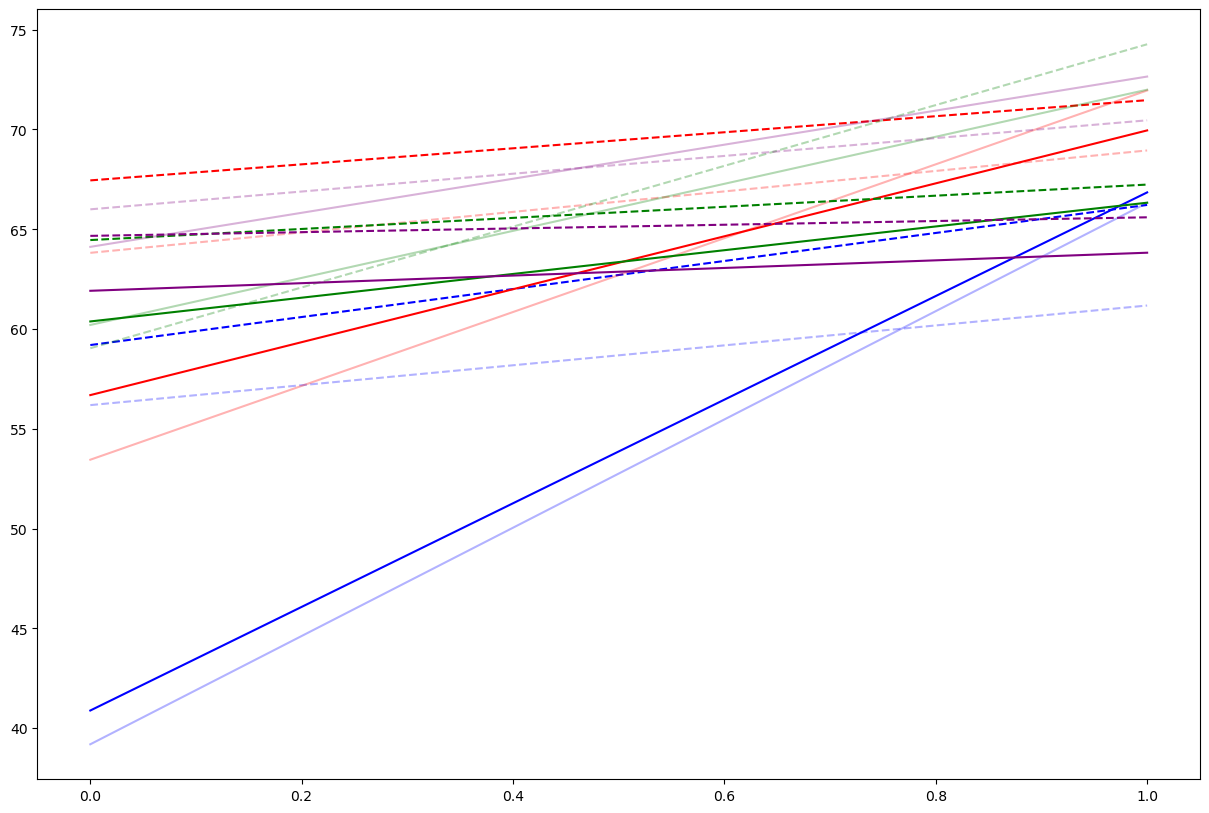

In [ ]:
# Example usage
if __name__ == "__main__":
    custom_config = ExperimentConfig(
        seeds=[42, 122],
        epochs_per_phase=30,
        batch_size=128,
        learning_rate=0.001,
        probe_points=['conv1', 'conv2', 'conv3', 'conv4',
                           'conv5', 'conv6', 'fc1'],
        dropout_rates=[0.0, 0.5]
    )

    # Run experiment with frozen layers
    results_frozen, timestamp_frozen = run_experiment(custom_config, freeze_previous=True)
    
    # Run experiment without frozen layers
    results_unfrozen, timestamp_unfrozen = run_experiment(custom_config, freeze_previous=False)

    # Plot comparison
    plot_frozen_vs_unfrozen_comparison(results_frozen, results_unfrozen, custom_config)

    # Print summaries
    frozen_summary = analyze_results(results_frozen)
    unfrozen_summary = analyze_results(results_unfrozen)


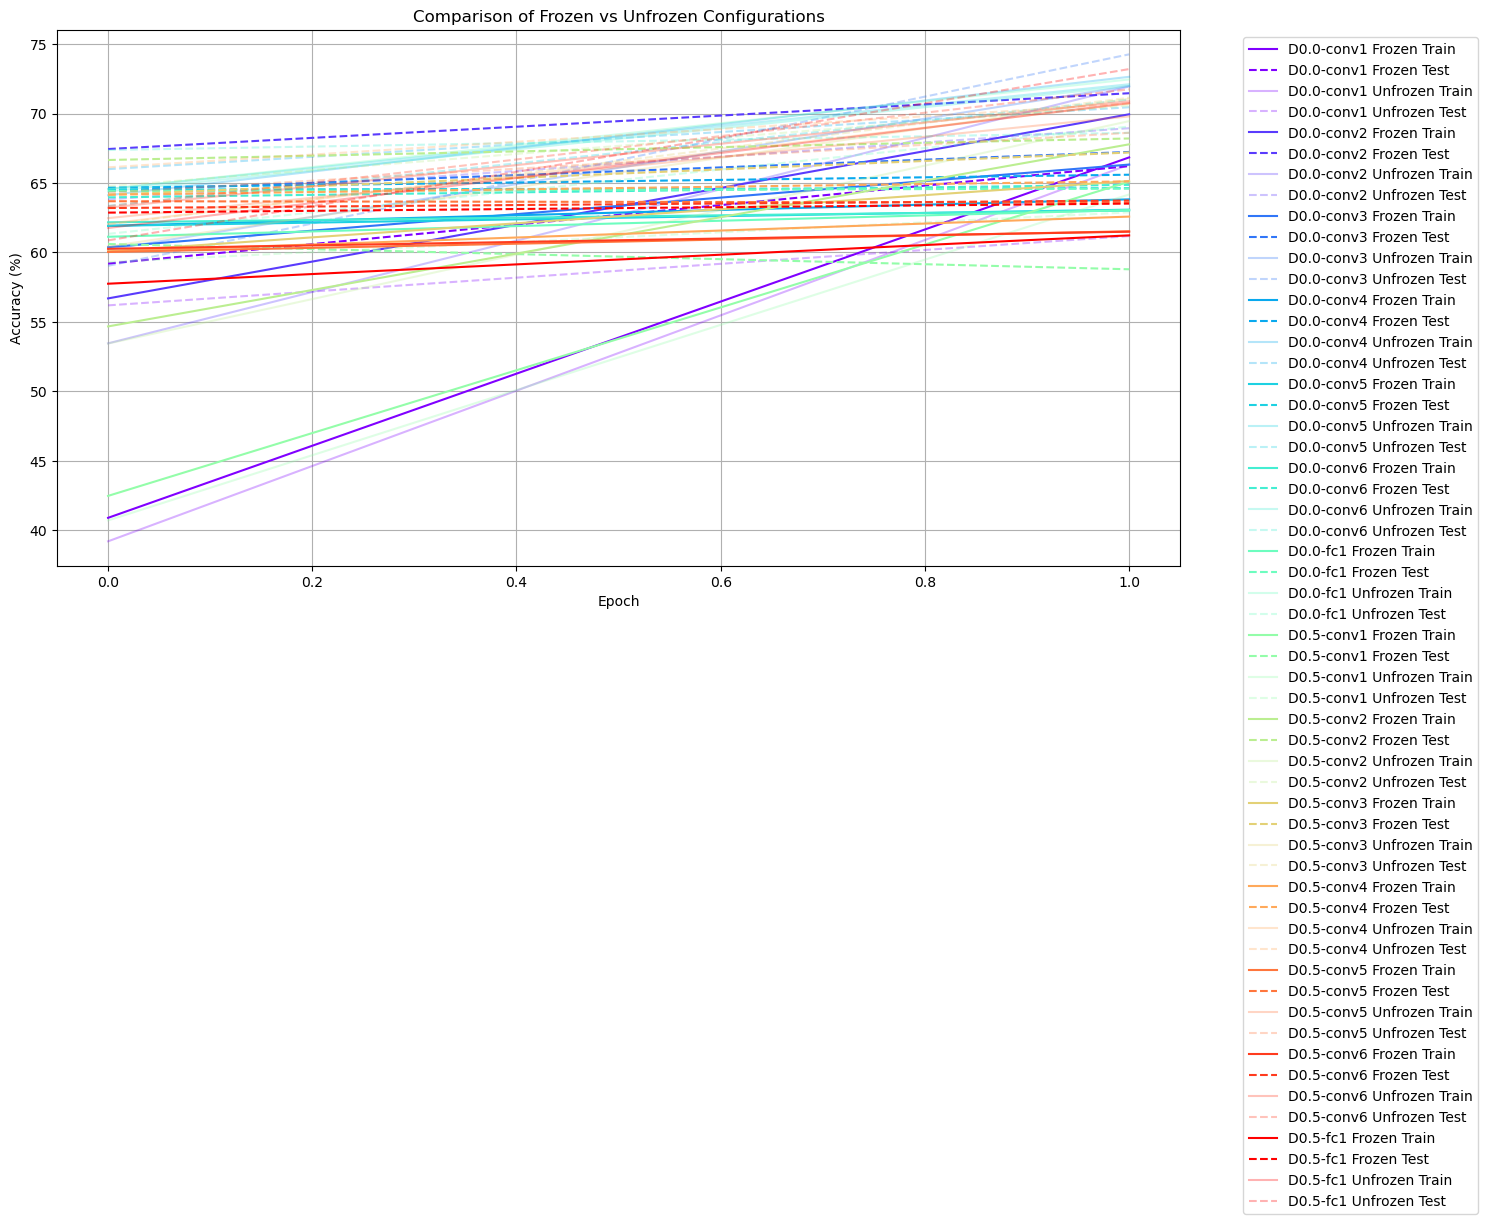

In [25]:

# Plot comparison
plot_frozen_vs_unfrozen_comparison(results_frozen, results_unfrozen, custom_config)

# Print summaries
frozen_summary = analyze_results(results_frozen)
unfrozen_summary = analyze_results(results_unfrozen)
